# Gaussian Processes for Orientation Preference Maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from opm import make_opm, plot_opm, plot_amplitude_map, get_indices
from pinwheels import plot_pinwheels
from response import response, create_stimuli, compute_responses
from kernels import mexican_hat_kernel
from gp import GaussianProcessOPM, prior_covariance

## Ground truth map

For computational simplicity, we create an OPM of lower dimensionality. Additionally, we need the (x,y) indices for every pixel.

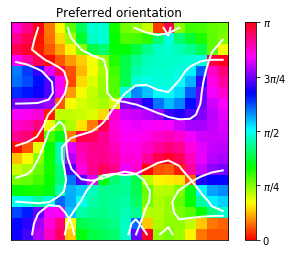

In [2]:
size = 20

n = size**2
d = 3

# ground truth opm
m = make_opm(size=size, sigma=2., k=2.)

f, ax = plot_opm(m)
plot_pinwheels(m, ax)

plt.show()

idx = get_indices(size)

## Responses
The responses are computed exactly the same way as before.

In [3]:
# compute responses
contrasts = [1.]
orientations = [i * np.pi / 8 - np.pi/2 for i in range(8)]
repetitions = 8

V = create_stimuli(contrasts, orientations, repetitions)

# number of trials
N = V.shape[0]

R = compute_responses(m, contrasts, orientations, repetitions, sigma=0.01)

np.allclose(V.T @ V, N / 2 * np.eye(d))
(V.T @ V).round(5)

array([[32.,  0., -0.],
       [ 0., 32.,  0.],
       [-0.,  0., 32.]])

In [4]:
V.shape

(64, 3)

## Prior covariance
For the prior covariance, a Mexican hat kernel (approximated by a difference of Gaussians) is used:

$$
K_{prior}(x, x') = \sum_{a,b=1}^{2} \frac{\alpha_a \alpha_b}{2 \pi (\alpha_a^2 + \alpha_b^2}) \, exp(-\frac{1}{2} (\frac{||x - x'||^2}{\alpha_a^2 + \alpha_b^2}))
$$

The kernel has three parameters:
- $\sigma$, the standard deviation of the positive Gaussian ($\sigma_1$)
- $k$, the scaling factor for the standard deviation of the negative Gaussian w.r.t. that of the positive Gaussian ($\frac{\sigma_2}{\sigma_1}$)
- $\alpha$, an overall scaling factor ($\alpha_1 = -\alpha_2$)



Here, this kernel function is visualized for the one-dimensional case with two different parameter settings.

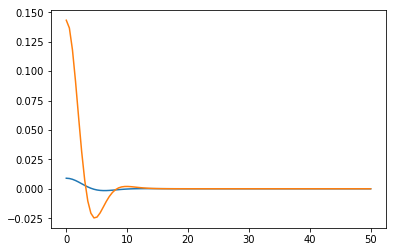

In [5]:
xx = np.linspace(0, 50, 100)[:,np.newaxis]
plt.plot(xx, mexican_hat_kernel(xx, 0, sigma=2., k=2., alpha=1.))
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=0.5, alpha=3.))
plt.show()


The prior covariance matrix $K$ for a set of indices is now computed as the kernel function between every combination of indices. The spectrum of eigenvalues of $K$ quickly drops off. There are however some negative eigenvalues, since $K$ is not positive definite

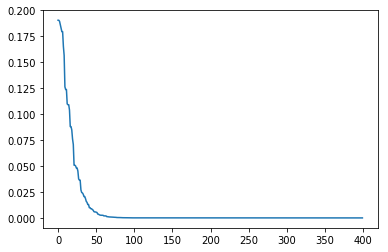

In [6]:
K = prior_covariance(idx, kernel=mexican_hat_kernel, sigma=2.)


eigvals = np.linalg.eigvalsh(K)

plt.plot(eigvals[::-1])
plt.show()

## Determining prior hyperparameters
We want to fit the parameters of our prior to the autocorrelation function of the empirical map. For this, we need to compute the autocorrelations of the real and imaginary parts of a map and then compute the rotational average of these.

In [7]:
a = np.real(m)
b = np.imag(m)

from scipy.signal import correlate2d

In [8]:
xcorr = correlate2d(b, b) / b.size


def rot_avg(xcorr, spacing=None):
    
    
    s1 = (xcorr.shape[0] - 1) / 2
    s2 = (xcorr.shape[1] - 1) / 2
    x, y = np.meshgrid(np.arange(-s2, s2+1), np.arange(-s1, s1+1))

    rs = np.sqrt(x**2 + y**2)
    
    if spacing is None:
        
        r = np.unique(rs)
        n = np.zeros(r.size)
        rotmean = np.zeros(r.size)
        rotstd = np.zeros(r.size)
        
        for k in range(r.size):

            values = xcorr[rs == r[k]]
            rotmean[k] = values.mean()
            n[k] = values.size
            rotstd[k] = values.std()
            
    else:   
        
        r = np.zeros(spacing.size - 1)
        n = np.zeros(spacing.size - 1)
        rotmean = np.zeros(spacing.size - 1)
        rotstd = np.zeros(spacing.size - 1)
        
        for k in range(spacing.size - 1):
            r[k] = spacing[k]
            
            values = xcorr[(rs >= spacing[k] - 1e-30) & (rs < spacing[k+1])]
                           
            rotmean[k] = values.mean()
            n[k] = values.size
            rotstd[k] = values.std()
    
    return rotmean, r, rotstd, n
    
#mean, r, std, n = rot_avg(xcorr, spacing=np.arange(100))
mean, r, _std, _n = rot_avg(xcorr, spacing=np.arange(25))

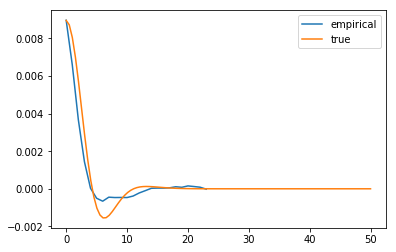

In [9]:
plt.plot(r, mean, label='empirical')
plt.plot(xx, mexican_hat_kernel(xx, 0, sigma=2., k=2., alpha=1.), label='true')
plt.legend()

In [10]:
from scipy.optimize import curve_fit

def mexhat(r, sigma, alpha):
    return mexican_hat_kernel(r[:,np.newaxis], 0, sigma=sigma, alpha=alpha)

popt, pcov = curve_fit(mexhat, xdata=r[1:], ydata=mean[1:], p0=[3.,2.])

sigma_opt, alpha_opt = popt
popt

array([1.81333975, 0.79526456])

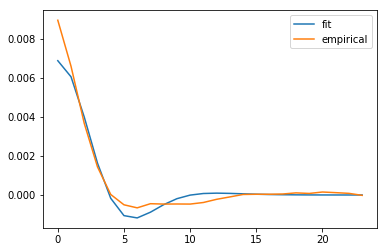

In [11]:
plt.plot(r, mexican_hat_kernel(r[:,np.newaxis], 0, sigma=sigma_opt, alpha=alpha_opt), label='fit')
plt.plot(r, mean, label='empirical')
plt.legend()

In [13]:
gp = GaussianProcessOPM(size=size, prior_method='icd', prior_rank=100, sigma=sigma_opt, alpha=alpha_opt)

## Noise covariance
We assume for now (for simplicity) that the noise covariance is known and the noise is i.i.d. and Gaussian with variance $\sigma_{\epsilon}$:

$\Sigma_{\epsilon} = \sigma_{\epsilon}\mathbb{I}_n$

In [14]:
# assume that the noise covariance is know (iid Gaussian noise)
sigma_e = 0.1
K_e = np.eye(n) * sigma_e

## Gaussian Process Posterior

The covariance and mean of the Gaussian process posterior can be obtained as:

$ \Sigma_{post}^{-1} = K_m^{-1} + (\sum_i v_i v_i^T) \otimes \Sigma_{\epsilon}^{-1}$

$ \mu_{post} = \Sigma_{post} (\mathbb{I}_d \otimes \Sigma_{\epsilon}^{-1}) \sum_i v_i \otimes \mathbf{r}_i $

In [15]:
mu_post = gp.fit(V, R, K_e)

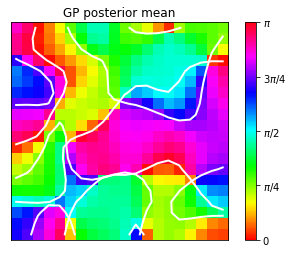

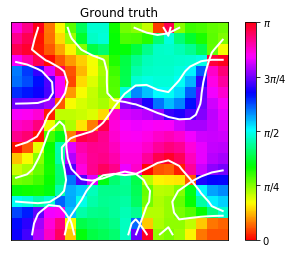

In [16]:
mu = mu_post.reshape(d, size, size)
result = mu[0] + 1j * mu[1]
f, ax = plot_opm(result, title='GP posterior mean')
plot_pinwheels(result, ax)
plt.show()

f, ax = plot_opm(m, title='Ground truth')
plot_pinwheels(m, ax)
plt.show()